<a href="https://colab.research.google.com/github/thomas1608/phy466/blob/main/ExamAssignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Galaxy Classification, Anomaly Detection, Autoencoder & VAE (Keras)
This notebook uses the Galaxy10 DECaLS dataset (astronomical galaxy images) for:

1. Data loading & splitting, defining an anomaly class  
2. CNN classifier + ROC curves & confusion matrices  
3. Convolutional autoencoder for anomaly detection  
4. Variational autoencoder (VAE) + galaxy generation

Dataset: Galaxy10 DECaLS (HDF5).

In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import tensorflow as tf

from tensorflow import keras # (changed) sticking to tf.keras
from tensorflow.keras import layers, ops, Model, random, regularizers, optimizers, models

import numpy as np
import h5py
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

## 1. Download the dataset, inspect classes, create anomaly split

Steps:
- Download `Galaxy10_DECals_64.h5`
- Load images and labels with `h5py`
- Inspect shape and class distribution
- Remove class 0 and store it as the anomaly dataset
- Split remaining (standard) data into train (50%), val (25%), test (25%)

In [2]:
# Download Galaxy10 DECaLS (HDF5)
! rm ./Galaxy10_DECals_64.h5
! wget https://cernbox.cern.ch/remote.php/dav/public-files/RyWK8CBk2yqKR0b/Galaxy10_DECals_64.h5
data_path = "./Galaxy10_DECals_64.h5"

print("Downloaded to:", data_path)

--2025-12-14 20:26:52--  https://cernbox.cern.ch/remote.php/dav/public-files/RyWK8CBk2yqKR0b/Galaxy10_DECals_64.h5
Resolving cernbox.cern.ch (cernbox.cern.ch)... 137.138.120.151, 128.142.53.28, 128.142.53.35, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|137.138.120.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 159140118 (152M) [application/octet-stream]
Saving to: ‘Galaxy10_DECals_64.h5’

Galaxy10_DECals_64. 100%[===================>] 151.77M  18.9MB/s    in 9.1s    

2025-12-14 20:27:02 (16.8 MB/s) - ‘Galaxy10_DECals_64.h5’ saved [159140118/159140118]

Downloaded to: ./Galaxy10_DECals_64.h5


In [3]:
# Load images and labels using h5py
with h5py.File(data_path, "r") as f:
    images = np.array(f["images"])   # shape (17736, 64, 64, 3) (changed from 256 to 64)
    labels = np.array(f["ans"])      # shape (17736,)

#  normalize pixels in [0,1]
images = images.astype("float32") / 255.0


print("Images shape:", images.shape)
print("Labels shape:", labels.shape, "dtype:", labels.dtype)


Images shape: (17736, 64, 64, 3)
Labels shape: (17736,) dtype: uint8


In [4]:
# Class names from the Galaxy10 DECaLS documentation
class_names = {
    0: "Disturbed Galaxies",
    1: "Merging Galaxies",
    2: "Round Smooth Galaxies",
    3: "In-between Round Smooth Galaxies",
    4: "Cigar Shaped Smooth Galaxies",  # will be 'anomaly'
    5: "Barred Spiral Galaxies",
    6: "Unbarred Tight Spiral Galaxies",
    7: "Unbarred Loose Spiral Galaxies",
    8: "Edge-on Galaxies without Bulge",
    9: "Edge-on Galaxies with Bulge"
}

unique, counts = np.unique(labels, return_counts=True)
print("Class distribution:")
for u, c in zip(unique, counts):
    print(f"Class {u} ({class_names[u]}): {c}")

Class distribution:
Class 0 (Disturbed Galaxies): 1081
Class 1 (Merging Galaxies): 1853
Class 2 (Round Smooth Galaxies): 2645
Class 3 (In-between Round Smooth Galaxies): 2027
Class 4 (Cigar Shaped Smooth Galaxies): 334
Class 5 (Barred Spiral Galaxies): 2043
Class 6 (Unbarred Tight Spiral Galaxies): 1829
Class 7 (Unbarred Loose Spiral Galaxies): 2628
Class 8 (Edge-on Galaxies without Bulge): 1423
Class 9 (Edge-on Galaxies with Bulge): 1873


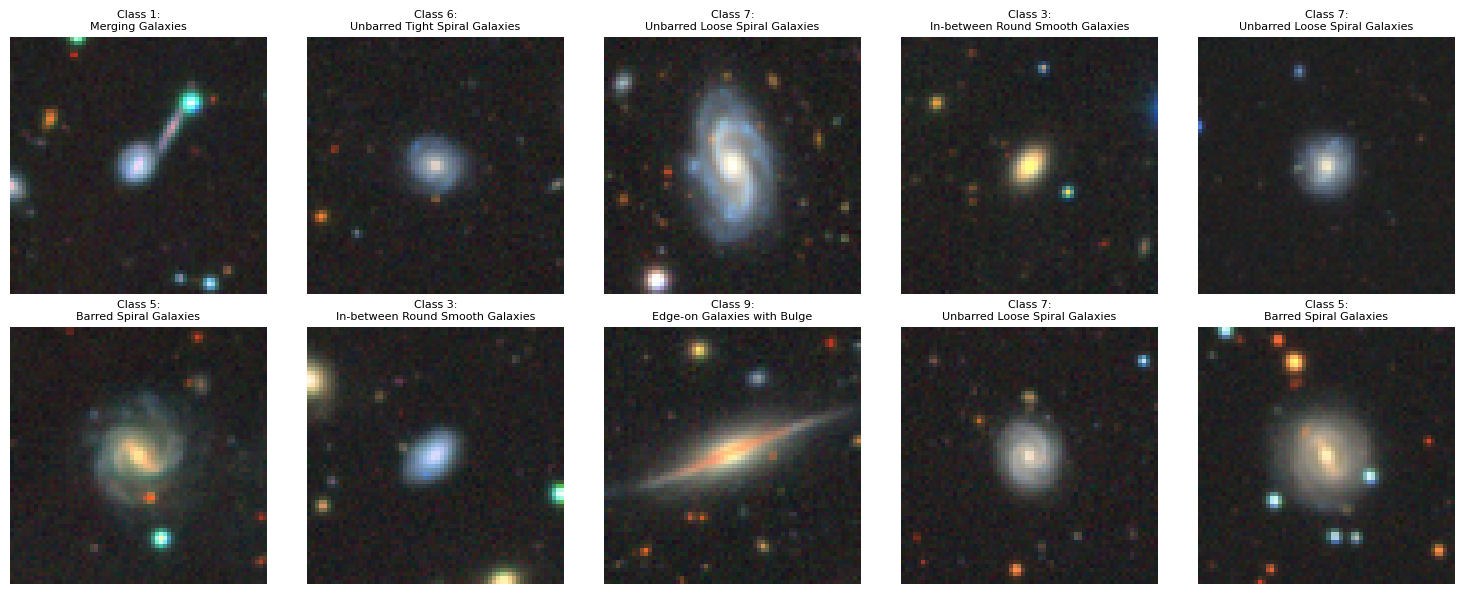

In [5]:
# Show a grid of sample images from different classes
def show_examples(images, labels, class_names, n_rows=2, n_cols=5):
    plt.figure(figsize=(3*n_cols, 3*n_rows))
    indices = np.random.choice(len(images), size=n_rows*n_cols, replace=False)
    for i, idx in enumerate(indices):
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(images[idx])
        plt.title(f"Class {labels[idx]}:\n{class_names[int(labels[idx])]}", fontsize=8)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_examples(images, labels, class_names)

In [41]:
# Create anomaly dataset: all class 0 images
ANOMALY_CLASS = 0

anomaly_mask = (labels == ANOMALY_CLASS)
standard_mask = ~anomaly_mask

anom_images = images[anomaly_mask]
anom_labels = labels[anomaly_mask]  # all 0, but we keep them for bookkeeping

std_images = images[standard_mask]
std_labels_original = labels[standard_mask]

print("Standard images:", std_images.shape)
print("Anomaly images:", anom_images.shape)

Standard images: (16655, 64, 64, 3)
Anomaly images: (1081, 64, 64, 3)


In [42]:
# For training, remap standard labels from {0,1,2,3,5,6,7,8,9} -> {0,...,8}
unique_std_classes = sorted(np.unique(std_labels_original))
print("Standard classes (original indices):", unique_std_classes)

# Create mapping dict
label_map = {original: new for new, original in enumerate(unique_std_classes)}
inv_label_map = {v: k for k, v in label_map.items()}

print("Label map (original -> new):", label_map)

std_labels = np.vectorize(label_map.get)(std_labels_original)
print("Remapped standard labels min/max:", std_labels.min(), std_labels.max())
n_classes = len(unique_std_classes)
print(n_classes)

Standard classes (original indices): [np.uint8(1), np.uint8(2), np.uint8(3), np.uint8(4), np.uint8(5), np.uint8(6), np.uint8(7), np.uint8(8), np.uint8(9)]
Label map (original -> new): {np.uint8(1): 0, np.uint8(2): 1, np.uint8(3): 2, np.uint8(4): 3, np.uint8(5): 4, np.uint8(6): 5, np.uint8(7): 6, np.uint8(8): 7, np.uint8(9): 8}
Remapped standard labels min/max: 0 8
9


In [43]:
# Split standard data: 50% train, 25% val, 25% test

# First split: train (50%) and temp (50%)
X_train_std, X_temp_std, y_train_std, y_temp_std = train_test_split(
    std_images,
    std_labels,
    test_size=0.5,
    stratify=std_labels,
    random_state=42
)

# Second split: temp into val (25%) and test (25%) of full standard data
X_val_std, X_test_std, y_val_std, y_test_std = train_test_split(
    X_temp_std,
    y_temp_std,
    test_size=0.5,
    stratify=y_temp_std,
    random_state=42
)

print("Train standard:", X_train_std.shape, y_train_std.shape)
print("Val standard:  ", X_val_std.shape, y_val_std.shape)
print("Test standard: ", X_test_std.shape, y_test_std.shape)
del std_images, std_labels, X_temp_std, y_temp_std

Train standard: (8327, 64, 64, 3) (8327,)
Val standard:   (4164, 64, 64, 3) (4164,)
Test standard:  (4164, 64, 64, 3) (4164,)


## 2. CNN classifier + ROC curves + confusion matrices

Steps:
- Build a CNN classifier on the **standard** dataset (9 classes)
- Train on train set, validate on val set
- Plot training history (loss & accuracy)
- Compute ROC curves (one-vs-rest) on the standard test set
- Compute confusion matrix for standard test

Build a CNN classifier on the standard dataset (9 classes)

In [44]:
data_augmentation = keras.Sequential([
    layers.RandomRotation(1.0),
    layers.RandomZoom(0.1)
])


def build_simple_cnn(input_shape, n_classes):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)

    # Conv blocks
    x = layers.Conv2D(32, 3, padding="same", activation="relu",
                      kernel_regularizer=regularizers.l2(1e-3))(x)

    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(64, 3, padding="same", activation="relu",
                      kernel_regularizer=regularizers.l2(1e-3))(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(128, 3, padding="same", activation="relu",
                      kernel_regularizer=regularizers.l2(1e-3))(x)
    x = layers.MaxPooling2D(2)(x)

    # Dense layer
    x = layers.Flatten()(x)  # 8192
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation="relu",
                     kernel_regularizer=regularizers.l2(1e-3))(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(n_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


# Build model
input_shape = X_train_std.shape[1:]  # (64, 64, 3)
model = build_simple_cnn(input_shape, n_classes)
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,192,969 (8.37 MB)

 Trainable params: 2,192,969 (8.37 MB)

 Non-trainable params: 0 (0.00 B)

Train on train set, validate on val set

In [45]:
# Train the CNN
batch_size = 64
epochs = 100

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True,
    ),
]


history = model.fit(
    X_train_std, y_train_std,
    validation_data=(X_val_std, y_val_std),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
)


Epoch 1/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.2011 - loss: 2.3169 - val_accuracy: 0.3461 - val_loss: 1.8203
Epoch 2/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.3471 - loss: 1.7786 - val_accuracy: 0.4270 - val_loss: 1.5633
Epoch 3/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.4603 - loss: 1.5690 - val_accuracy: 0.5329 - val_loss: 1.4411
Epoch 4/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.4893 - loss: 1.5001 - val_accuracy: 0.5293 - val_loss: 1.3814
Epoch 5/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5282 - loss: 1.4395 - val_accuracy: 0.5677 - val_loss: 1.3425
Epoch 6/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5355 - loss: 1.4208 - val_accuracy: 0.6021 - val_loss: 1.2594
Epoch 7/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.5717 - loss: 1.3444 - val_accuracy: 0.6369 - val_loss: 1.2034
Epoch 8/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.5719 - loss: 1.3280 - 

Plot training history (loss & accuracy)

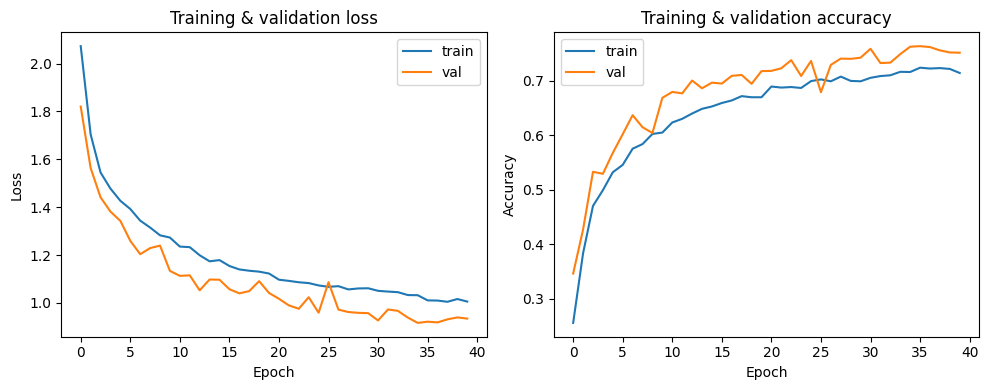

In [46]:
# Plot training history: loss & accuracy
history_dict = history.history

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history_dict["loss"], label="train")
plt.plot(history_dict["val_loss"], label="val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & validation loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_dict["accuracy"], label="train")
plt.plot(history_dict["val_accuracy"], label="val")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training & validation accuracy")
plt.legend()

plt.tight_layout()
plt.show()

Predictions on the standard test set

In [47]:
y_proba_test = model.predict(X_test_std)
y_pred_test = np.argmax(y_proba_test, axis=1)

print("Test accuracy (overall):", np.mean(y_pred_test == y_test_std))

131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Test accuracy (overall): 0.7641690682036504


Compute ROC curves (one-vs-rest) on the standard test set

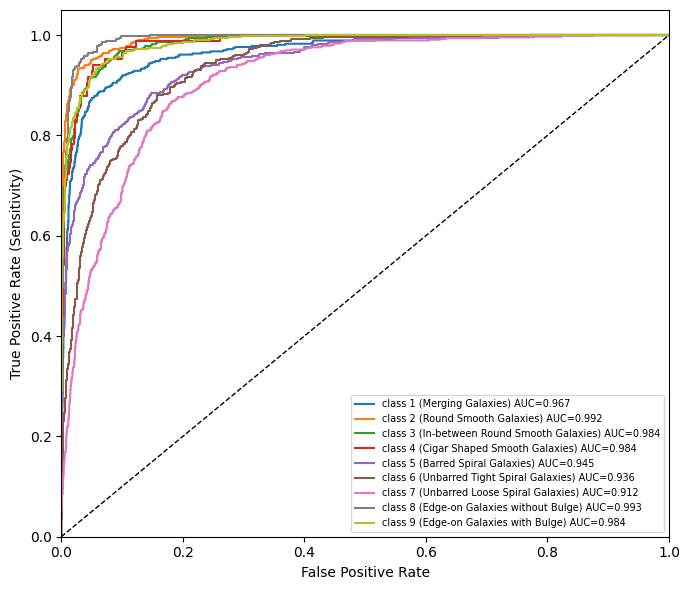

In [48]:
classes = np.unique(y_test_std)
plt.figure(figsize=(7,6))

for c in classes:
    # binary labels: 1 if this class, 0 otherwise
    y_true_c = (y_test_std == c).astype(int)
    y_score_c = y_proba_test[:, c]

    fpr, tpr, _ = roc_curve(y_true_c, y_score_c)
    roc_auc = auc(fpr, tpr)

    original_label = inv_label_map[int(c)]
    label_name = class_names[original_label]
    plt.plot(fpr, tpr, lw=1.5, label=f"class {original_label} ({label_name}) AUC={roc_auc:.3f}")

plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.legend(fontsize=7)
plt.tight_layout()
plt.show()


Compute confusion matrix for standard test

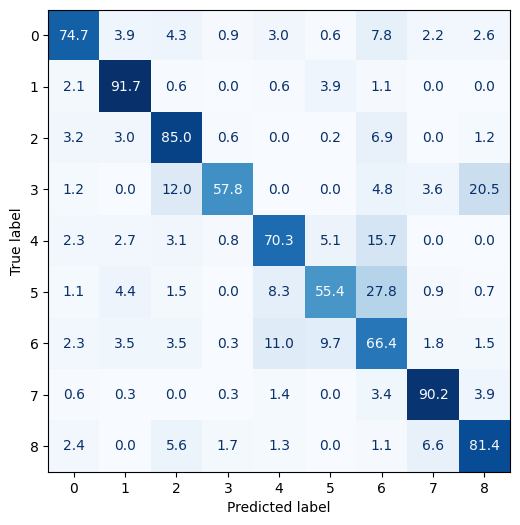

In [49]:
cm = confusion_matrix(y_test_std, y_pred_test, normalize="true") * 100

fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax, cmap="Blues", colorbar=False, values_format=".1f")
plt.show()


## 3. Convolutional Autoencoder for anomaly detection

Steps:
- Train a convolutional autoencoder on **standard** train set only
- Plot training history
- Compute reconstruction loss (MSE) per image for:
  - Standard test set
  - Anomaly dataset (class 4)
- Plot histograms of reconstruction losses
- Use reconstruction loss as anomaly score and build ROC curve & confusion matrix (adapt provided code)

Train a convolutional autoencoder on standard train set only

In [15]:
def build_conv_autoencoder(input_shape=(64, 64, 3)):

    # Encoder
    inputs = keras.Input(shape=input_shape)

    x = layers.Conv2D(32, (3, 3), padding="same", activation="relu")(inputs)
    x = layers.MaxPooling2D((2, 2), padding="same")(x)   # 64 -> 32

    x = layers.Conv2D(64, (3, 3), padding="same", activation="relu")(x)
    encoded = layers.MaxPooling2D((2, 2), padding="same", name="latent")(x)  # 32 -> 16

    # Decoder
    x = layers.Conv2D(64, (3, 3), padding="same", activation="relu")(encoded)
    x = layers.UpSampling2D((2, 2))(x)                   # 16 -> 32

    x = layers.Conv2D(32, (3, 3), padding="same", activation="relu")(x)
    x = layers.UpSampling2D((2, 2))(x)                   # 32 -> 64

    outputs = layers.Conv2D(
        3, (3, 3),
        padding="same",
        activation="sigmoid",   # images in [0,1]
        name="reconstruction",
    )(x)

    autoencoder = keras.Model(inputs, outputs, name="conv_autoencoder_simple")
    autoencoder.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="mse",
    )
    return autoencoder

# Build model
input_shape = X_train_std.shape[1:]  # (64, 64, 3)
autoencoder = build_conv_autoencoder(input_shape)
autoencoder.summary()


Model: "conv_autoencoder_simple"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (MaxPooling2D)           │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reconstruction (Conv2D)         │ (None, 64, 64, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,651 (295.51 KB)

 Trainable params: 75,651 (295.51 KB)

 Non-trainable params: 0 (0.00 B)

Plot training history


In [16]:
batch_size = 64
epochs = 100

ae_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True,
    )
]


history_ae = autoencoder.fit(
    X_train_std, X_train_std,
    validation_data=(X_val_std, X_val_std),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=ae_callbacks,
)



hist = history_ae.history


Epoch 1/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - loss: 0.0430 - val_loss: 0.0023
Epoch 2/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 3/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0012 - val_loss: 9.4423e-04
Epoch 4/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 9.5666e-04 - val_loss: 8.6755e-04
Epoch 5/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 8.7002e-04 - val_loss: 8.1299e-04
Epoch 6/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 8.0282e-04 - val_loss: 7.7825e-04
Epoch 7/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 7.9081e-04 - val_loss: 7.6873e-04
Epoch 8/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 7.6366e-04 - val_loss: 7.2811e-04
Epoch 9/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 7.3460e-04 - val_loss: 7.2626e-04
Epoch 10/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 7.1969e-04 - val_loss: 6.9211e-04
Epoch 11/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - l

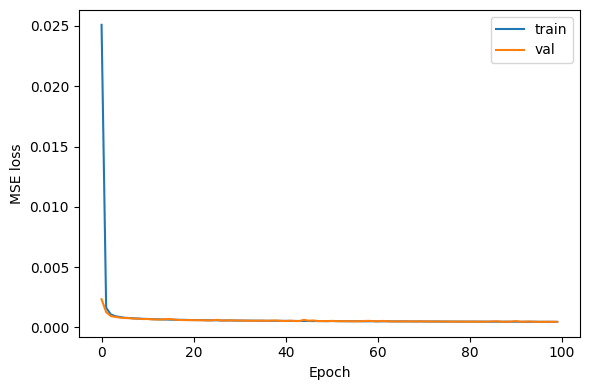

In [17]:
plt.figure(figsize=(6, 4))
plt.plot(hist["loss"], label="train")
plt.plot(hist["val_loss"], label="val")
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.legend()
plt.tight_layout()
plt.show()


Compute reconstruction loss (MSE) per image for:
- Standard test set
- Anomaly dataset (class 4)

In [18]:
# Reconstruction on standard test set
X_test_std_recon = autoencoder.predict(X_test_std, batch_size=64, verbose=1)
recon_loss_std = np.mean(
    np.square(X_test_std_recon - X_test_std),
    axis=(1, 2, 3)
)

# Reconstruction on anomaly set (class 0
anom_recon = autoencoder.predict(anom_images, batch_size=64, verbose=1)
recon_loss_anom = np.mean(
    np.square(anom_recon - anom_images),
    axis=(1, 2, 3)
)

print("Reconstruction loss (standard test):")
print("  mean =", recon_loss_std.mean(), "std =", recon_loss_std.std())
print("Reconstruction loss (anomaly):")
print("  mean =", recon_loss_anom.mean(), "std =", recon_loss_anom.std())


66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
Reconstruction loss (standard test):
  mean = 0.0004624402 std = 0.00011665816
Reconstruction loss (anomaly):
  mean = 0.00046646656 std = 0.0001133837


Plot histograms of reconstruction losses

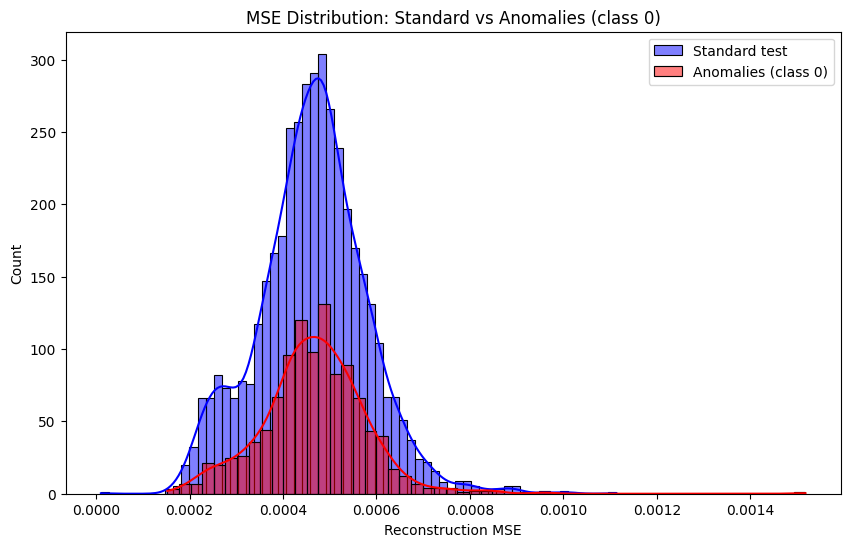

In [19]:
plt.figure(figsize=(10,6))
sns.histplot(recon_loss_std,  label='Standard test', color='blue', kde=True)
sns.histplot(recon_loss_anom, label='Anomalies (class 0)', color='red', kde=True)
plt.title('MSE Distribution: Standard vs Anomalies (class 0)')
plt.xlabel('Reconstruction MSE')
plt.ylabel('Count')
plt.legend()
plt.show()


Use reconstruction loss as anomaly score and build ROC curve & confusion matrix (adapt provided code)

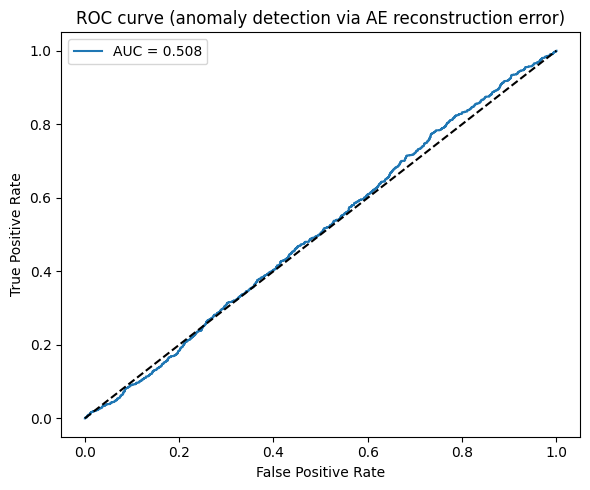

In [20]:
# Build labels and scores
y_true_ae = np.concatenate([
    np.zeros_like(recon_loss_std, dtype=int),   # 0 = standard
    np.ones_like(recon_loss_anom, dtype=int),   # 1 = anomaly
])
scores_ae = np.concatenate([recon_loss_std, recon_loss_anom])

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true_ae, scores_ae)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve (anomaly detection via AE reconstruction error)")
plt.legend()
plt.tight_layout()
plt.show()


Threshold: 0.00037548469845205545


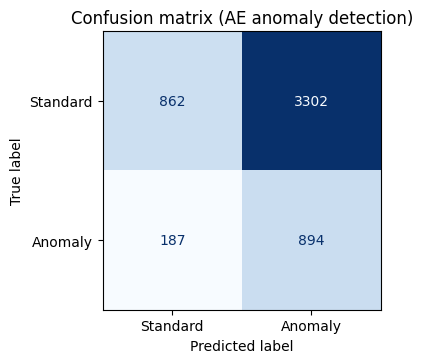

In [21]:
percentile = 20
best_thresh = np.percentile(scores_ae, percentile)
y_pred_ae = (scores_ae >= best_thresh).astype(int)

cm_ae = confusion_matrix(y_true_ae, y_pred_ae)
print(f"Threshold: {best_thresh}")

fig, ax = plt.subplots(figsize=(4, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_ae,
                              display_labels=["Standard", "Anomaly"])
disp.plot(ax=ax, cmap="Blues", colorbar=False)
plt.title("Confusion matrix (AE anomaly detection)")
plt.tight_layout()
plt.show()


## 4. Variational Autoencoder (VAE) on standard data

Steps:
- Build a VAE with convolutional encoder/decoder (trained on standard train set)
- Plot training history
- Generate new galaxy images from the VAE
- Visualize some generated images

Build a VAE with convolutional encoder/decoder (trained on standard train set)

In [22]:
# Sampling layer
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the latent vector."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim   = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon


latent_dim = 128

# Encoder
enc_inputs = keras.Input(shape=(64, 64, 3))
x = layers.Conv2D(16, 3, padding="same", activation="relu")(enc_inputs)
x = layers.MaxPooling2D((2, 2), padding="same")(x)        # 64 -> 32
x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)        # 32 -> 16

# Latent Space
shape_before_flatten = x.shape[1:]   # (16, 16, 32)
x = layers.Flatten()(x)              # 8192
x = layers.Dense(256, activation="relu")(x)

z_mean    = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z         = Sampling()([z_mean, z_log_var])

encoder = keras.Model(enc_inputs, [z_mean, z_log_var, z], name="encoder")

# Decoder
dec_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(np.prod(shape_before_flatten), activation="relu")(dec_inputs)
x = layers.Reshape(shape_before_flatten)(x)               # (16, 16, 32)

x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)
x = layers.UpSampling2D((2, 2))(x)                        # 16 -> 32
x = layers.Conv2D(16, 3, padding="same", activation="relu")(x)
x = layers.UpSampling2D((2, 2))(x)                        # 32 -> 64

dec_outputs = layers.Conv2D(3, 3, padding="same", activation="sigmoid")(x)
decoder = keras.Model(dec_inputs, dec_outputs, name="decoder")

decoder.summary()


# VAE model class
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]


    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            sq_err = ops.square(data - reconstruction)
            per_example_loss = ops.sum(sq_err, axis=(1, 2, 3))
            reconstruction_loss = ops.mean(per_example_loss)

            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))

            beta = 0.1  # helps generation
            total_loss = reconstruction_loss + beta * kl_loss


        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8192)           │     1,056,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 64, 64, 3)      │           435 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,071,075 (4.09 MB)

 Trainable params: 1,071,075 (4.09 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
batch_size = 64
epochs = 100

vae_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="reconstruction_loss",
        patience=5,
        restore_best_weights=True,
        mode="min",
    )
]

history_vae = vae.fit(
    X_train_std,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=vae_callbacks,
)


Epoch 1/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - kl_loss: 182.7891 - loss: 397.3351 - reconstruction_loss: 379.0562
Epoch 2/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - kl_loss: 50.8564 - loss: 67.8435 - reconstruction_loss: 62.7578
Epoch 3/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - kl_loss: 55.2753 - loss: 57.5929 - reconstruction_loss: 52.0654
Epoch 4/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - kl_loss: 55.0548 - loss: 51.9874 - reconstruction_loss: 46.4819
Epoch 5/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - kl_loss: 53.6332 - loss: 47.7228 - reconstruction_loss: 42.3595
Epoch 6/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - kl_loss: 50.7924 - loss: 44.8047 - reconstruction_loss: 39.7255
Epoch 7/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - kl_loss: 49.2361 - loss: 42.0498 - reconstruction_loss: 37.1262
Epoch 8/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - kl_loss: 47.6337 - loss: 40.3971 - reconstruction_loss: 35.6338
Epoch 9/100
131/131 ━━━━━━━━━━━━━━━━

Plot training history

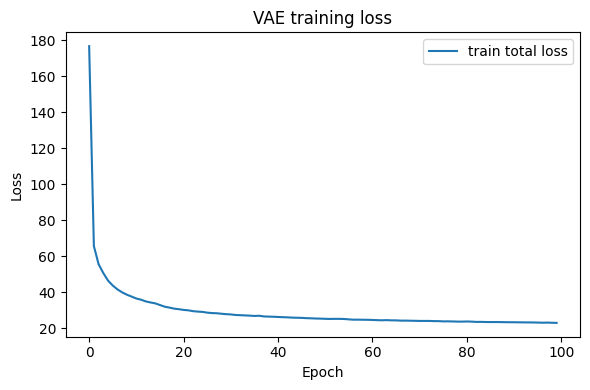

In [24]:
hist = history_vae.history

plt.figure(figsize=(6, 4))
plt.plot(hist["loss"], label="train total loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("VAE training loss")
plt.legend()
plt.tight_layout()
plt.show()

Generate new galaxy images from the VAE

In [25]:
def generate_random_galaxies(decoder, latent_dim, n):
    # Sample random points in latent space ~ N(0, I)
    z_random = np.random.normal(size=(n, latent_dim)).astype("float32")
    generated = decoder.predict(z_random)

    plt.figure(figsize=(n * 1.6, 2))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        img = generated[i]
        img = np.clip(img, 0.0, 1.0)
        plt.imshow(img)
        plt.axis("off")
    plt.show()


Visualize some generated images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


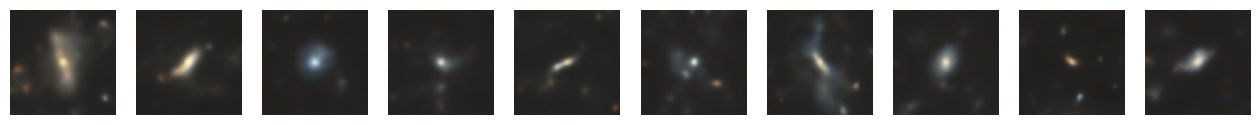

In [40]:
generate_random_galaxies(decoder, latent_dim=latent_dim, n=10)